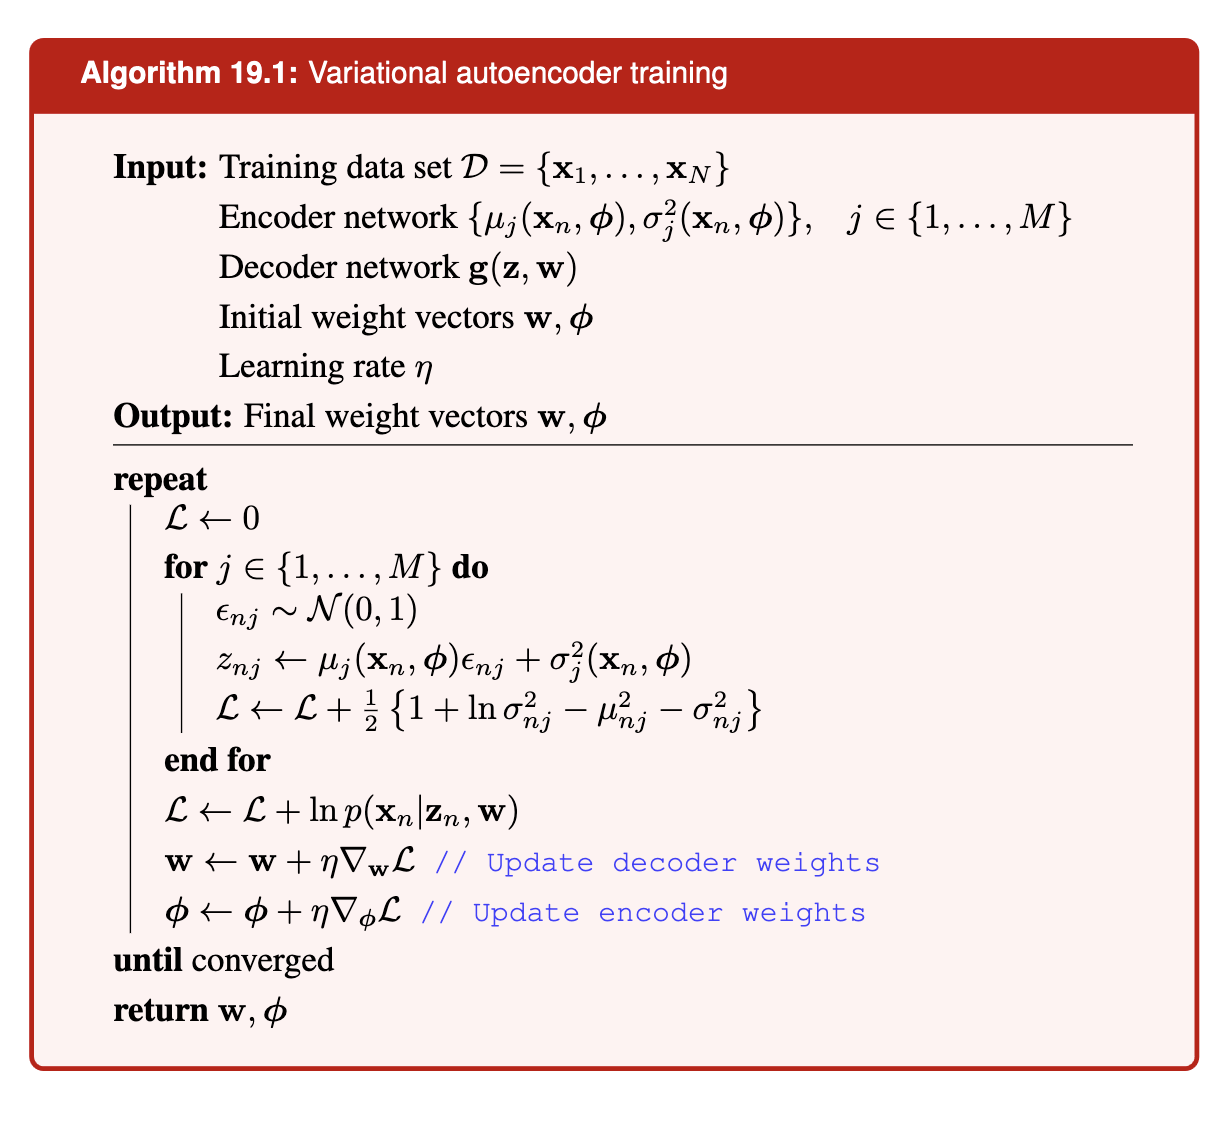

M = size of mini-batch

VAE från Google [https://arxiv.org/pdf/2208.11970.pdf](https://arxiv.org/pdf/2208.11970.pdf)

VAE is a likelihood-based model consisting of a Encoder and a Decoder.


# Overview

Three key ideas in VAE:

- (i) use of ELBO to approximate the likehood function
- (ii) amortized inference for the encoder network
- (iii) training of encoder tractable due to _reparameterization trick_

# Encoder

Formalized as $q_\phi(z|x)$. Encoder network usually either CNN or MLP:

- CNN good for images
- MLP good for everything

# Decoder

Formalized as $p_\theta(x|z)$. Converts a latent vector into an observation.

# Loss Function

Split the loss function into two parts:

- (i) reconstruction term -- $E_{q_\phi(z|x)}[\log p_\theta(x|z)]$
- (ii) KL divergence (or _prior matching term_) -- $D_{KL}(q_\phi(z|x) || p (z))$ -- can be integrated analytically when latent variables are modelled with known distributions. Interpreted as regularizing $\phi$ and pushing it close to the prior $p_\theta(z)$

The aim is to **maximize** the reconstruction term, and **minimize** the KL divergence term, pushing the encoder to be close to the unknown prior $p(x)$. The loss term is called the _evidence lower bound_ (ELBO):

$$
\mathcal{L}(\theta, \phi; x) = E_{q_\phi(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_\phi(z|x) || p (z))
$$

The objective is to maximize the negative ELBO.

# Optimizizer

- SGD
- AdaGrad
- ADAM


In [ ]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# Set the data path, batch size, and device
data_path = "path_to_your_data"  # Replace with the path to your data
batch_size = 64  # Set your batch size
device = (
    "cuda" if torch.cuda.is_available() else "cpu"
)  # Choose 'cuda' or 'cpu' based on your system

# Initialize the MNIST dataset and DataLoader
train_dataset = MNIST(
    root=data_path, train=True, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Open a file in write mode
with open("testing_mnist.txt", "w") as file:
    for x, _ in train_loader:
        # Reshape x to [batch_size, width * height]
        batch_size, _, width, height = x.shape
        x = x.reshape(batch_size, width * height).to(device)

        # Iterate over each image in the batch
        for image in x:
            # Convert the image tensor to a list and write it to the file
            image_data = image.cpu().numpy().tolist()
            file.write(",".join(map(str, image_data)) + "\n")

print("Data saved to testing_mnist.txt")

In [88]:
# this little quick and dirty chatgpt solution always works
import sys
sys.path.append('../')  # Add the parent directory to sys.path

import argparse
from pathlib import Path

import wandb
from tqdm import tqdm
from dotenv import load_dotenv

import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from models.VAE import VAE
from models.encoders_and_decoders import GaussianMLP, BernoulliDecoder
from utils.losses import evidence_lower_bound
from utils.utils import get_device

%load_ext autoreload
%autoreload 2

def train(model, optimizer, epochs, device, train_loader, loss_function):
    """
    Main training loop
    """
    model.train()
    losses = []
    for epoch in range(epochs):
        mean_max = []
        mean_min = []
        logvar_max = []
        logvar_min = []
        running_loss = 0.0
        for x, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            # x shape is [batch_size, channels, 28, 28]
            batch_size, _, width, height = x.shape

            # vectorize image
            x = x.reshape(batch_size, width * height).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            x_hat, mean, log_var = model(x)
            # assert that the mean and logvar contains no NaNs
            # print the highest and lowest values of mean and logvar
            mean_max.append(mean.max().item())
            mean_min.append(mean.min().item())
            logvar_max.append(log_var.max().item())
            logvar_min.append(log_var.min().item())
            # save min and max values of mean and logvar to
            if torch.isnan(mean).any():
                import pandas as pd
                import seaborn as sns
                import matplotlib.pyplot as plt
                df = pd.DataFrame({"mean_max": mean_max, "mean_min": mean_min, "logvar_max": logvar_max, "logvar_min": logvar_min})
                # plot a line for each of the values using seaborn, with logscale on y-axis
                sns.lineplot(data=df, palette="tab10", linewidth=2.5)
                plt.yscale("log")
                raise ValueError("mean contains NaNs")

            # backwards pass: compute loss and its gradients
            reconstruction_loss, DKL = loss_function(x, x_hat, mean, log_var)

            elbo = reconstruction_loss + DKL
            elbo.backward()

            # Adjust learning weights
            optimizer.step()

            running_loss += elbo.item()
            # logg my three losses

        # at the end of each epoch, log the loss
        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)
    return losses


epochs = 10
batch_size = 128
input_dim = 784
hidden_dim = 400
latent_dim = 2
learning_rate = 1e-4
seed = 42
device = None


"""
wandb.init(
    project="DD2434",
    entity="skolprojekt",
    config={
        "epochs": args.epochs,
        "batch_size": args.batch_size,
        "input_dim": args.input_dim,
        "hidden_dim": args.hidden_dim,
        "latent_dim": args.latent_dim,
        "seed": args.seed,
        "device": args.device,
        "dataset": args.dataset,
        "optimizer": args.optimizer,
        "learning_rate": args.learning_rate,
    },
)
"""

# setting this to "none" will default to the "best" available device: CUDA, MPS (Apple M1), or CPU
device = get_device(device=device)


encoder = GaussianMLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=latent_dim)

decoder = BernoulliDecoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=input_dim)

# instantiate model
model = VAE(
    device=device,
    encoder=encoder,
    decoder=decoder,
).to(device)

# setup optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)

# set up data transformations
# Define the threshold function
def binarize_image(img):
    return (img > 0.8).float()

def unnormalize_image(img):
    return img * 255




transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# download dataset
data_path = ".." / Path("data")


train_dataset = MNIST(
    root=data_path, train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = MNIST(data_path, transform=transform, download=True)


train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

# setup loss (higher order function)
elbo = evidence_lower_bound

losses = train(
    model=model,
    optimizer=optimizer,
    epochs=epochs,
    device=device,
    train_loader=train_loader,
    loss_function=elbo,
)
# store the model in wandb (not only state_dict)

# evaluera på test set
# skapa bilder från latent space och spara i wandb, göra några olika traversals? kanske ska ske i inference.py
# traversal_of_them_latency_space = ...
# wandb.log({"example": wandb.Image("myimage.jpg")})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Epoch 10: 100%|██████████| 469/469 [00:05<00:00, 83.96it/s]


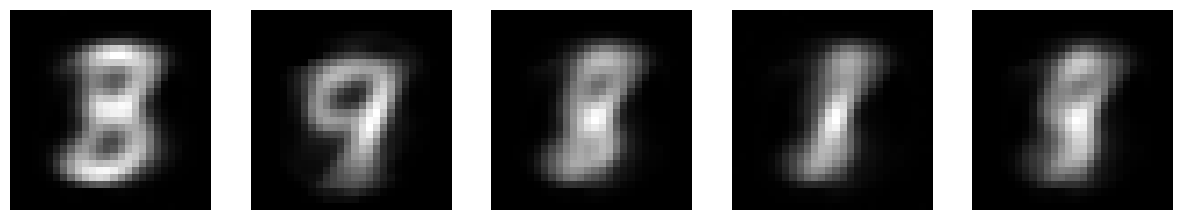

In [102]:
generated_data = model.sample(batch_size=5)
generated_data = generated_data.reshape(5, 1, 28, 28).to("cpu").detach().numpy()

# plot the generated data
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax[i].imshow(generated_data[i, 0, :, :], cmap="gray")
    ax[i].axis("off")

In [115]:
latent_walk = model.latent_walk(z_start=-1.0, z_end=1.0, steps=10)

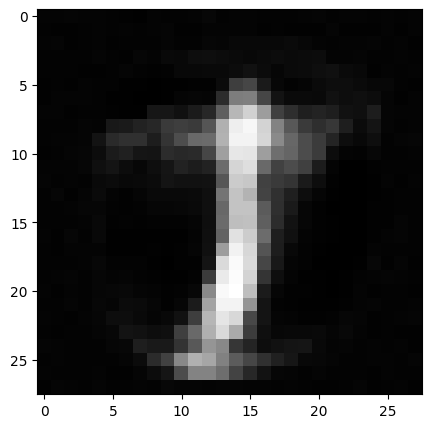

In [114]:
picture = model.decoder.forward(z=torch.tensor([0.0, 10]).to(device))

picture = picture.reshape(1, 1, 28, 28).to("cpu").detach().numpy()

# plot the generated data
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(picture[0, 0, :, :], cmap="gray")

torch.Size([400, 784])


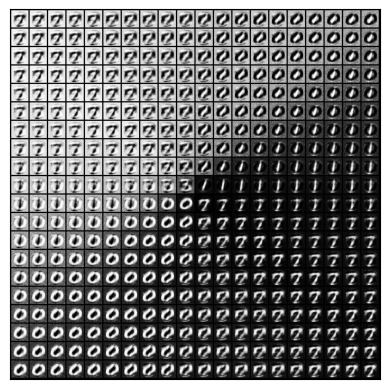

In [122]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


z_start = -100
z_end = 100
steps = 20


# make a grid of xs, ys
z_grid = torch.stack(
    [
        torch.stack([x, y], dim=0)
        for x in torch.linspace(z_start, z_end, steps).to(device)
        for y in torch.linspace(z_start, z_end, steps).to(device)
    ],
    dim=0,
)

# Decode each point along the walk
generated_data = torch.stack([model.decode(z) for z in z_grid], dim=0)

generated_data.shape
# reshape to [8, 8, 28, 28])
print(generated_data.shape)

from torchvision.utils import make_grid
generated_data = generated_data.reshape(steps*steps, 1, 28, 28)
grid = make_grid(generated_data, nrow=steps)
show(grid)

torch.Size([49, 784])


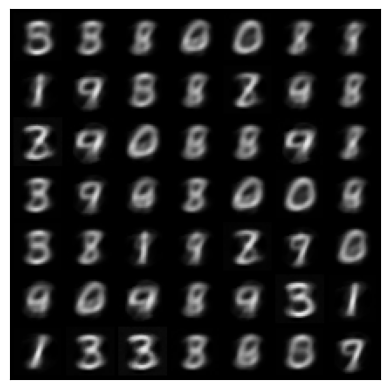

In [143]:
batch = model.sample(batch_size=49)
batch = batch.reshape(49, 1, 28, 28)
grid = make_grid(batch.reshape(49, 1, 28, 28), nrow=7)
show(grid)

In [ ]:
train_dataset = MNIST(
    root=data_path, train=True, transform=transforms.ToTensor(), download=True
)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# display some vectors from the trainloader
for x, _ in train_loader:
    # x shape is [batch_size, channels, 28, 28]
    batch_size, _, width, height = x.shape
    x = x.reshape(batch_size, width * height).to(device)
    # save x to a file
    print(x.max())